# FINAL PROJECT TALENT CLASS - DATA SCIENCE

Created by: _Data Science Indonesia_ <br><br>
_COPYRIGHT ALL RIGHT RESERVED TO DATA SCIENCE INDONESIA_

## Install Packages / Library

In [1]:
# DO THIS if not yet install by default

!pip install imbalanced-learn
!pip install xgboost

## Load the Library

In [2]:
import numpy as np

import pandas as pd
pd.set_option('display.max_columns', None)

import plotly.express as px
import plotly.graph_objects as go

import sqlite3

from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.metrics import average_precision_score, roc_auc_score, roc_curve, auc
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBClassifier, XGBRegressor

import seaborn as sns

import pickle as pkl

## Load the Data

We have data on:

 - what internet services customers use
 - type of contract
 - the lifetime of the customer in the service (tenure)
 - payment method
 - the amount of monthly payments of customers and their total costs in the service
 - customer locations
 - gender and age of the customer
 - reason for churn (only for churn customer)

In [4]:
# Read Excel file, please adjust the file path based on your directory
df = pd.read_excel('Telco_customer_churn.xlsx', sheet_name='Telco_Churn')

# Convert 'Total Charges' to numeric datatype from object, setting errors='coerce' for forcing the invalid parse to be NaN
df['Total Charges'] = pd.to_numeric(df['Total Charges'], errors='coerce')

# Drop Column Count since irrelevant
df = df.drop(columns='Count')

# Get the dataframe information
df.info()

# Display the dataframe
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 32 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerID         7043 non-null   object 
 1   Country            7043 non-null   object 
 2   State              7043 non-null   object 
 3   City               7043 non-null   object 
 4   Zip Code           7043 non-null   int64  
 5   Lat Long           7043 non-null   object 
 6   Latitude           7043 non-null   float64
 7   Longitude          7043 non-null   float64
 8   Gender             7043 non-null   object 
 9   Senior Citizen     7043 non-null   object 
 10  Partner            7043 non-null   object 
 11  Dependents         7043 non-null   object 
 12  Tenure Months      7043 non-null   int64  
 13  Phone Service      7043 non-null   object 
 14  Multiple Lines     7043 non-null   object 
 15  Internet Service   7043 non-null   object 
 16  Online Security    7043 

,CustomerID,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,No,No,Yes,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,No,No,Yes,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.50,Yes,1,86,5372,Moved
3,7892-POOKP,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,No,No,Yes,49,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.30,Yes,1,89,5340,Competitor had better devices
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,2569-WGERO,United States,California,Landers,92285,"34.341737, -116.539416",34.341737,-116.539416,Female,No,No,No,72,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Bank transfer (automatic),21.15,1419.40,No,0,45,5306,NaN
7039,6840-RESVB,United States,California,Adelanto,92301,"34.667815, -117.536183",34.667815,-117.536183,Male,No,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,No,0,59,2140,NaN
7040,2234-XADUH,United States,California,Amboy,92304,"34.559882, -115.637164",34.559882,-115.637164,Female,No,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,No,0,71,5560,NaN
7041,4801-JZAZL,United States,California,Angelus Oaks,92305,"34.1678, -116.86433",34.167800,-116.864330,Female,No,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No,0,59,2793,NaN


## Handling Missing Value

Because of the _coercing effect_ there are null values on Total Charges column

On this one, we don't want to drop the NaN even though it safe to do so

Instead, try to replace the null values with the close approximate value using formula:  
> **'Calculated Charges' = 'Monthly Charges' * 'Tenure Months'**

The calculated charges will get result close to the original Total Charges value

In [5]:
# See how many null values on Total Charges
df.isna().sum()

,0
CustomerID,0
Country,0
State,0
City,0
Zip Code,0
Lat Long,0
Latitude,0
Longitude,0
Gender,0
Senior Citizen,0


In [6]:
# Create new column named Calculated Charges
df['Calculated Charges'] = df['Monthly Charges'] * df['Tenure Months']

# Replace the missing values/NaN on Total Charges using Calculated Charges, if Total Charges is not NaN keep as is
df['Total Charges'] = np.where(df['Total Charges'].isna(), df['Calculated Charges'], df['Total Charges'])

df = df.drop(columns='Calculated Charges')

In [7]:
# RUN IT AGAIN, See how many null values on Total Charges
df.isna().sum()

,0
CustomerID,0
Country,0
State,0
City,0
Zip Code,0
Lat Long,0
Latitude,0
Longitude,0
Gender,0
Senior Citizen,0


## Exploratory Data Analysis

#### 1. Create a "PLOTLY" pie chart to show how many Churn and Non-Churn customer using _Churn Label_ & _CustomerID_

In [8]:
fig = px.pie(df.groupby('Churn Label')['CustomerID'].count().reset_index(),
             values='CustomerID',
             names='Churn Label')
fig.show()

#### 2. Create a "PLOTLY" bar chart to show 15 city are having the "most customer" using _City_ & _CustomerID_

In [9]:
fig = px.bar(df.groupby(['City'])['CustomerID'].count().reset_index().sort_values('CustomerID', ascending=False).head(10),
             x='City',
             y='CustomerID',
             color='CustomerID',
             text='CustomerID')
fig.show()

#### 3. Create a "PLOTLY" histogram to show the lifetime of customer using _Tenure Months_ & _Churn Label_

In [12]:
# Create the violin plot
fig = px.violin(df, x="Tenure Months", color="Churn Label", box=True, points="all")

# Customize layout for better visualization if needed
fig.update_layout(
    xaxis_title="Tenure Months",
    yaxis_title="Distribution",
    title="Distribution of Tenure Months by Churn Label"
)

# Show the plot
fig.show()

#### 4. Create a "PLOTLY" heatmap to show the correlation how contract types affect churn of the customers using _Churn Label_ & _Contract_

In [14]:
# Create a crosstab to show the correlation between Contract and Churn Label
correlation_data = pd.crosstab(df['Contract'], df['Churn Label']
[df['Churn Label'] == 'Yes'])

# Create a heatmap using plotly.graph_objects
fig = go.Figure(data=go.Heatmap(
    z=correlation_data.values,
    x=correlation_data.columns,
    y=correlation_data.index,
    colorscale='RdYlGn_r',
    text=correlation_data.values,
    texttemplate="%{text}",
    textfont={"size": 12}
))

fig.update_layout(
    title='Correlation between Contract and Churn Label',
    xaxis_title='Churn Label',
    yaxis_title='Contract',
    width=500,  # Adjust the width of the graph
    height=800  # Adjust the height of the graph
)

fig.show()

#### 5. Working with SQL in Python using SQLITE3

In [39]:
# Establish a connection by creating a database engine
connection = sqlite3.connect('tc17finalproject.db')

# Convert Dataframe into SQL with current connection
df.to_sql('finalproject', connection, if_exists='replace', index=False)

# Create a cursor object to allow execution of SQL commands
cur = connection.cursor()

#### a) Find which TOP 10 cities are
- having the "most churn customers"
#### using _City_, _CustomerID_, and _Churn Label_ in descending order

In [16]:
# Your SQL Query Goes here
query = '''
SELECT "City", COUNT("CustomerID") as ChurnCount
FROM finalproject
WHERE "Churn Label" = 'Yes'
GROUP BY "City"
ORDER BY ChurnCount DESC
LIMIT 10;
'''

# Execute the SQL Query
cur.execute(query)
rows = cur.fetchall()

# Print the SQL Query results
for row in rows:
    print(row)

('Los Angeles', 90)
('San Diego', 50)
('San Francisco', 31)
('San Jose', 29)
('Sacramento', 26)
('Fresno', 16)
('Long Beach', 15)
('Oakland', 13)
('Glendale', 13)
('Stockton', 12)


#### b) Find which customer total charges that
- below average total charges of customer who use "mailed check" as payment method AND
- total charges "is not 0"
#### using CustomerID, Payment Method, and Total Charges in ascending order

In [18]:
# Your SQL Query Goes here
query = '''
SELECT "CustomerID", "Payment Method", "Total Charges"
FROM finalproject
WHERE "Total Charges" < (SELECT AVG("Total Charges")
                         FROM finalproject WHERE "Payment Method" = 'Mailed check'
                         ) AND "Total Charges" IS NOT NULL
ORDER BY "Total Charges" ASC;
'''

# Execute the SQL Query
cur.execute(query)
rows = cur.fetchall()

# Print the SQL Query results
for row in rows:
    print(row)

('4472-LVYGI', 'Bank transfer (automatic)', 0.0)
('3115-CZMZD', 'Mailed check', 0.0)
('5709-LVOEQ', 'Mailed check', 0.0)
('4367-NUYAO', 'Mailed check', 0.0)
('1371-DWPAZ', 'Credit card (automatic)', 0.0)
('7644-OMVMY', 'Mailed check', 0.0)
('3213-VVOLG', 'Mailed check', 0.0)
('2520-SGTTA', 'Mailed check', 0.0)
('2923-ARZLG', 'Mailed check', 0.0)
('4075-WKNIU', 'Mailed check', 0.0)
('2775-SEFEE', 'Bank transfer (automatic)', 0.0)
('2967-MXRAV', 'Mailed check', 18.8)
('9318-NKNFC', 'Mailed check', 18.85)
('8992-CEUEN', 'Electronic check', 18.85)
('9975-SKRNR', 'Mailed check', 18.9)
('1423-BMPBQ', 'Mailed check', 19.0)
('1015-OWJKI', 'Mailed check', 19.05)
('6121-VZNQB', 'Mailed check', 19.1)
('6569-KTMDU', 'Mailed check', 19.1)
('9441-QHEVC', 'Mailed check', 19.1)
('7302-ZHMHP', 'Mailed check', 19.15)
('1663-MHLHE', 'Mailed check', 19.2)
('3308-MHOOC', 'Mailed check', 19.2)
('4232-JGKIY', 'Electronic check', 19.2)
('3373-YZZYM', 'Mailed check', 19.2)
('5510-BOIUJ', 'Mailed check', 19.25)

## Data Preparation for ML Modelling

#### 1. Deleting the columns that we won't use and only select feature that related (feature selection process)

In [19]:
# Drop irrelevant columns
df = df.drop(columns=['Country', 'State', 'Zip Code', 'Churn Reason', 'City', 'Churn Label', 'CLTV', 'CustomerID', 'Lat Long',
                       'Latitude', 'Longitude'])

In [20]:
df.info()
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             7043 non-null   object 
 1   Senior Citizen     7043 non-null   object 
 2   Partner            7043 non-null   object 
 3   Dependents         7043 non-null   object 
 4   Tenure Months      7043 non-null   int64  
 5   Phone Service      7043 non-null   object 
 6   Multiple Lines     7043 non-null   object 
 7   Internet Service   7043 non-null   object 
 8   Online Security    7043 non-null   object 
 9   Online Backup      7043 non-null   object 
 10  Device Protection  7043 non-null   object 
 11  Tech Support       7043 non-null   object 
 12  Streaming TV       7043 non-null   object 
 13  Streaming Movies   7043 non-null   object 
 14  Contract           7043 non-null   object 
 15  Paperless Billing  7043 non-null   object 
 16  Payment Method     7043 

,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Value,Churn Score
0,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1,86
1,Female,No,No,Yes,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1,67
2,Female,No,No,Yes,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.50,1,86
3,Female,No,Yes,Yes,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,1,84
4,Male,No,No,Yes,49,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.30,1,89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Female,No,No,No,72,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Bank transfer (automatic),21.15,1419.40,0,45
7039,Male,No,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,0,59
7040,Female,No,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,0,71
7041,Female,No,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,0,59


#### 2. Changing categorical variables to numeric

In [21]:
# Encode categorical data
def encode_data(dataframe_series):
    if dataframe_series.dtype == 'object':
        dataframe_series = LabelEncoder().fit_transform(dataframe_series)
    return dataframe_series

In [22]:
df = df.apply(lambda x: encode_data(x))
df

,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Value,Churn Score
0,1,0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,3,53.85,108.15,1,86
1,0,0,0,1,2,1,0,1,0,0,0,0,0,0,0,1,2,70.70,151.65,1,67
2,0,0,0,1,8,1,2,1,0,0,2,0,2,2,0,1,2,99.65,820.50,1,86
3,0,0,1,1,28,1,2,1,0,0,2,2,2,2,0,1,2,104.80,3046.05,1,84
4,1,0,0,1,49,1,2,1,0,2,2,0,2,2,0,1,0,103.70,5036.30,1,89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,0,0,0,72,1,0,2,1,1,1,1,1,1,2,1,0,21.15,1419.40,0,45
7039,1,0,1,1,24,1,2,0,2,0,2,2,2,2,1,1,3,84.80,1990.50,0,59
7040,0,0,1,1,72,1,2,1,0,2,2,0,2,2,1,1,1,103.20,7362.90,0,71
7041,0,0,1,1,11,0,1,0,2,0,0,0,0,0,0,1,2,29.60,346.45,0,59


## Build, Train, Evaluate, and Making Prediction of ML Model

#### 1. Regression Model

In [23]:
# Prepare the data
X = df.drop(columns=['Churn Score'])
y = df['Churn Score']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the XGBoost Regressor
xgb_reg = XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.01, max_depth=5, random_state=42)

# Fit the model on the training data
xgb_reg.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgb_reg.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 260.8770751953125
Mean Absolute Error: 13.629361152648926
R^2 Score: 0.4113346338272095


In [24]:
# Make predictions on the entire dataset
predictions = np.round(xgb_reg.predict(X))

# Create a DataFrame with the original features and the predicted Churn Score
prediction_df = X.copy()
prediction_df['Predicted Churn Score'] = predictions

# If you want to include the actual Churn Score for comparison
prediction_df['Actual Churn Score'] = y
prediction_df.head(15)

,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Value,Predicted Churn Score,Actual Churn Score
0,1,0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,3,53.85,108.15,1,82.0,86
1,0,0,0,1,2,1,0,1,0,0,0,0,0,0,0,1,2,70.70,151.65,1,79.0,67
2,0,0,0,1,8,1,2,1,0,0,2,0,2,2,0,1,2,99.65,820.50,1,83.0,86
3,0,0,1,1,28,1,2,1,0,0,2,2,2,2,0,1,2,104.80,3046.05,1,81.0,84
4,1,0,0,1,49,1,2,1,0,2,2,0,2,2,0,1,0,103.70,5036.30,1,84.0,89
5,0,0,1,0,10,1,0,0,0,0,2,2,0,0,0,0,1,55.20,528.35,1,80.0,78
6,1,1,0,0,1,0,1,0,0,0,2,0,0,2,0,1,2,39.65,39.65,1,88.0,100
7,1,0,0,0,1,1,0,2,1,1,1,1,1,1,0,0,3,20.15,20.15,1,85.0,92
8,1,0,1,1,47,1,2,1,0,2,0,0,2,2,0,1,2,99.35,4749.15,1,81.0,77
9,1,0,1,0,1,0,1,0,0,2,0,0,0,0,0,0,2,30.20,30.20,1,86.0,97


#### 2. Classification Model

Oversampling method often happen on classification model to address **"Class Imbalance"** due to some of the class label have lower value compared to the other class. On this case in the data, the customer that labeled as 1 (churn customer) is more lower than customer not churn (0).

In [25]:
# Balancing the data by Oversampling using SMOTE
over = SMOTE(sampling_strategy=1)  # sampling_strategy=1: The minority class will be oversampled to match the majority class.

x = df.drop(columns="Churn Value")
Y = df['Churn Value']

In [26]:
x,Y = over.fit_resample(x,Y)

In [27]:
x_train, x_test, Y_train, Y_test = train_test_split(x, Y, test_size=0.2, random_state=42)

In [28]:
def model(method, x_train, Y_train, x_test, Y_test):
    # Train the model
    method.fit(x_train, Y_train)

    # Make predictions on test data and calculate confusion matrix
    predictions = method.predict(x_test)
    c_matrix = confusion_matrix(Y_test, predictions)

    # Calculate label percentages and create label strings with counts and percentages
    percentages = (c_matrix / np.sum(c_matrix, axis=1)[:, np.newaxis]).round(2) * 100
    labels = [[f"{c_matrix[i, j]} ({percentages[i, j]:.2f}%)" for j in range(c_matrix.shape[1])] for i in range(c_matrix.shape[0])]
    labels = np.asarray(labels)

    # Plot confusion matrix with labeled counts and percentages
    sns.heatmap(c_matrix, annot=labels, fmt='', cmap='Blues')

    # Evaluate model performance and print results
    print("ROC AUC: ", '{:.2%}'.format(roc_auc_score(Y_test, predictions)))
    print("Model accuracy: ", '{:.2%}'.format(accuracy_score(Y_test, predictions)))
    print(classification_report(Y_test, predictions))

In [29]:
# Initialize XGBoost Classifier
xgb_class = XGBClassifier(learning_rate=0.01, max_depth=3, n_estimators=1000, subsample=0.8, colsample_bytree=0.8, random_state=42)

ROC AUC:  94.45%
Model accuracy:  94.49%
              precision    recall  f1-score   support

           0       0.96      0.92      0.94      1015
           1       0.93      0.96      0.95      1055

    accuracy                           0.94      2070
   macro avg       0.95      0.94      0.94      2070
weighted avg       0.95      0.94      0.94      2070



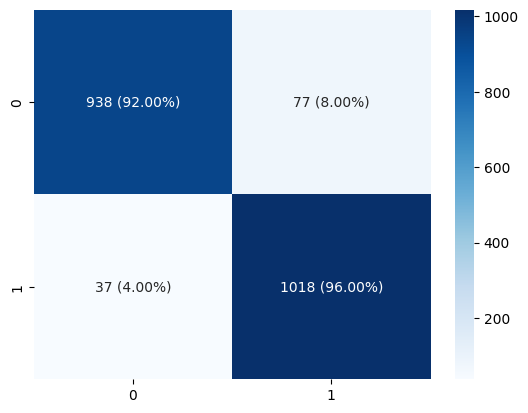

In [31]:
# Train and evaluate the model
model(xgb_class, x_train, Y_train, x_test, Y_test)

In [37]:
# Make predictions on the entire dataset
prediction2 = xgb_class.predict(x)

# Create a DataFrame with the original features and the predicted Churn Value
prediction_df2 = x.copy()
prediction_df2['Predicted Churn Value'] = prediction2

# If you want to include the actual Churn Value for comparison
prediction_df2['Actual Churn Value'] = Y.values

prediction_df2.head(15)

,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Score,Predicted Churn Value,Actual Churn Value
0,1,0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,3,53.85,108.15,86,1,1
1,0,0,0,1,2,1,0,1,0,0,0,0,0,0,0,1,2,70.70,151.65,67,1,1
2,0,0,0,1,8,1,2,1,0,0,2,0,2,2,0,1,2,99.65,820.50,86,1,1
3,0,0,1,1,28,1,2,1,0,0,2,2,2,2,0,1,2,104.80,3046.05,84,1,1
4,1,0,0,1,49,1,2,1,0,2,2,0,2,2,0,1,0,103.70,5036.30,89,1,1
5,0,0,1,0,10,1,0,0,0,0,2,2,0,0,0,0,1,55.20,528.35,78,1,1
6,1,1,0,0,1,0,1,0,0,0,2,0,0,2,0,1,2,39.65,39.65,100,1,1
7,1,0,0,0,1,1,0,2,1,1,1,1,1,1,0,0,3,20.15,20.15,92,1,1
8,1,0,1,1,47,1,2,1,0,2,0,0,2,2,0,1,2,99.35,4749.15,77,0,1
9,1,0,1,0,1,0,1,0,0,2,0,0,0,0,0,0,2,30.20,30.20,97,1,1


## Deploy ML Model

In [38]:
# Save the classification model to a pickle file
with open('xgb_class_model.pkl', 'wb') as file:
    pkl.dump(xgb_class, file)

# Save the regression model to a pickle file
with open('xgb_reg_model.pkl', 'wb') as file:
    pkl.dump(xgb_reg, file)

# Two files have been created and stored in your folder directory
print("Model saved to xgb_class_model.pkl & xgb_reg_model.pkl")

Model saved to xgb_class_model.pkl & xgb_reg_model.pkl


In conclusion,

Both regression model and classification model have their own challenge. Although classification seems more really reliable and accurate on this data, but the determination of the model only have exact two output either classified as churn or not.

Regression on the other hand, if we have another case study with better feature importance. It should improve the model performance by a lot. Causing model have lower deviation value from the original one. So in real life, many scoring system like pricing engine, recommendation system, credit scoring is a regression challenge that more being used on real life because its accuracy.